DECISION TIME MATTERS

This notebook was created as part of the educational project. You can find more information here: [NFL Big Data Bowl by Practicum](https://www.kaggle.com/code/ernestglukhov/nfl-big-data-bowl-by-practicum/notebook)

**Introduction**

*Hurry* is a situation when the QB is forced to throw the ball earlier than intended or is chased around/out of the pocket as the result of defensive pressure.  To prevent this, the offensive line protects the passer, providing precious seconds to find receivers downfield. We decided to find out how the amount of time a quarterback has to throw the ball affects the outcome of a pass.

**Methodology**

`Decision Time` is calculated as the number of seconds between the ball snap and the moment the first player on the defensive team gets within 2 yards or closer of the quarterback. 

With the help of statistical tests, we investigate the influence of the following factors on the result of a pass.
- The fact that the defense players got close to the quarterback.
- Amount of time the QB has to throw the ball.

**Steps**

1. **Data loading, EDA:** Selection of the parameters needed for the study. Exploring the possible outcomes of a play.


2. **Creation of functions to calculate** 
- distance from defense players to QB;
- moment a defensive player gets close to the QB.

3. **Calculation** of the desired time parameters for all available games.


4. **Examining differences**

- in pass results between two samples (Close / not Close);
- in decision times between two samples (Complete pass / Incomplete pass).

5. **Introducing new metric:** Decision Time

**Results**

We have found that there is a relationship between the time spent to make a decision and the result of the pass.


The faster the quarterback decides to throw the ball, the more likely it is that the pass will succeed. A bad block by offensive linemen means that the quarterback, in addition to finding the right receiver, has to spend time dodging defensive linemen. This increases the chances of an incomplete pass.

**Applicability of results**

We introduce a new metric: `Decision Time`.

- It can be used to evaluate both the success of the offensive linemen in restraining the attack of their opponents, and the effectiveness of breaking through the block by the linemen of the defense.

- Coaches can use this data to plan strategies for upcoming games by considering the average `Decision Time` per team/season.

This metric will also be intuitive to the viewer. Its values are easy to compare and can be considered within the framework of both pre-game and post-game statistics. For example:

Before the game between MIA and TB  |  After the game between DAL and TB
:-------------------------:|:-------------------------:
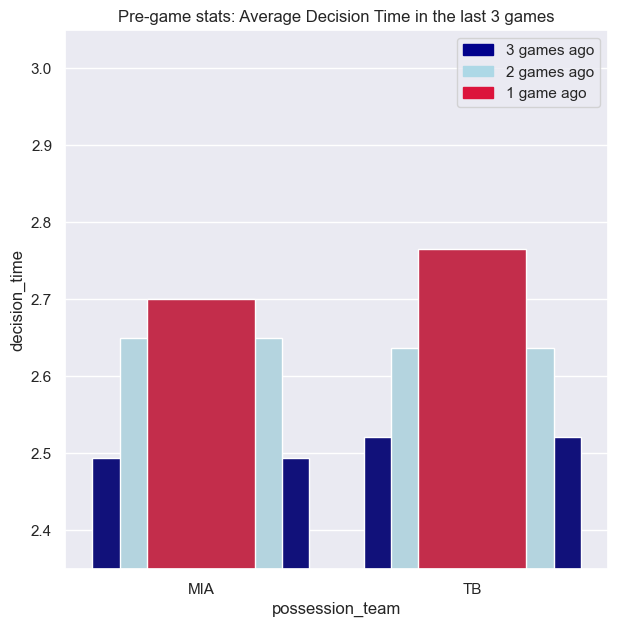 | 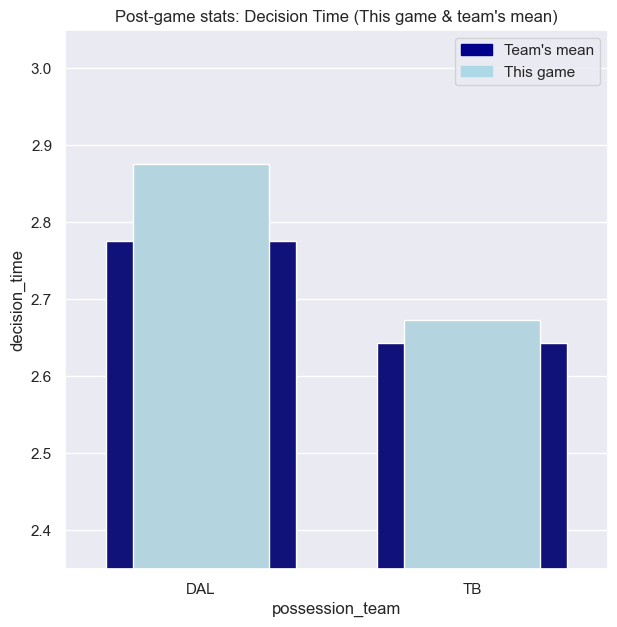

## EDA

In [1]:
import warnings
from itertools import repeat

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy import stats

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')

Loading data:

In [3]:
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/games.csv', index_col=['gameId'])
plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/plays.csv', index_col=['gameId', 'playId'])
players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/players.csv', index_col=['nflId'])
pff = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv', index_col=['gameId', 'playId', 'nflId'])

week1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week1.csv', index_col=['gameId', 'playId', 'nflId'])
week2 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week2.csv', index_col=['gameId', 'playId', 'nflId'])
week3 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week3.csv', index_col=['gameId', 'playId', 'nflId'])
week4 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week4.csv', index_col=['gameId', 'playId', 'nflId'])
week5 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week5.csv', index_col=['gameId', 'playId', 'nflId'])
week6 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week6.csv', index_col=['gameId', 'playId', 'nflId'])
week7 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week7.csv', index_col=['gameId', 'playId', 'nflId'])
week8 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week8.csv', index_col=['gameId', 'playId', 'nflId'])

Making column names snake_case:

In [4]:
def change_column_names(df):
    
    df.columns = (
        (df.columns.str[:1].str.upper() + df.columns.str[1:])
        .str.replace(r"([A-Z])", r" \1", regex=True)
        .str.lower().str.replace(' ', '_').str[1:]
    )
    return df

**Extracring data from files**

Selecting features usefull for the research:

In [5]:
plays_columns = [
    'possessionTeam', 'defensiveTeam', 
    'quarter', 'down', 'gameClock', 'passResult', 
    'personnelO', 'personnelD', 'playDescription'
]
pff_columns = [
    'pff_role', 'pff_positionLinedUp', 
    'pff_hurry', 'pff_hurryAllowed'
]
week_columns = [
    'frameId', 'time', 'jerseyNumber', 'team',
    'playDirection', 'x', 'y', 'event'
]
players_columns = ['officialPosition', 'displayName']

games = change_column_names(games)
plays = change_column_names(plays[plays_columns])
pff = change_column_names(pff[pff_columns])
players = change_column_names(players[players_columns])

weeks = [week1, week2, week3, week4, week5, week6, week7, week8]
tracking = pd.concat(weeks)
tracking = change_column_names(tracking)

Combining columns `game_date` and `game_time_eastern` into one datetime-type column.

In [6]:
games['datetime_est'] = pd.to_datetime(games.game_date + 'T' + games.game_time_eastern)
games.drop(['game_date', 'game_time_eastern', 'season', 'week'], axis=1, inplace=True)

Filling `NaN` values in nflId index (correspond to the football) so that the dataframe can be sorted and indexing becomes faster.

In [7]:
tracking.index = pd.MultiIndex.from_frame(tracking.index.to_frame().fillna(99999))

To datetime:

In [8]:
tracking.time = pd.to_datetime(tracking.time)

## Functions

**Distance to QB** - **`calculate_distances_to_qb`**

The function takes:
- tracking data; 
- game, play, QB and defensive player's nfl ids;
- minimal distance threshold between QB and defensive players

as parameters and returns a DataFrame containing information about whether the distance between each of the defense players at each time point was less than the threshold.

In [9]:
def calculate_distances_to_qb(tracking, game_id, play_id, qb_id, defensive_player_ids, min_dist):
    
    qb_track = tracking.loc[pd.IndexSlice[game_id, play_id, qb_id], ['x', 'y', 'time']].reset_index()
    
    for def_player_id in defensive_player_ids:
        
        def_player_track = tracking.loc[pd.IndexSlice[game_id, play_id, def_player_id], ['x', 'y']].reset_index()
        qb_track[str(def_player_id)] = (
            (np.sqrt((qb_track.x - def_player_track.x)**2 + (qb_track.y - def_player_track.y)**2) <= min_dist) * 1
        )
    qb_track['close'] = qb_track.loc[:, str(defensive_player_ids[0]):str(defensive_player_ids[-1])].sum(axis=1)
    
    return qb_track

The resulting dataframe looks like this (random play is considered).

In [10]:
dp = [41263, 42403, 43306, 43478, 44904, 44955, 44962, 47996, 52459, 53441, 53504]
new_qb_track = calculate_distances_to_qb(tracking, 2021090900, 97, 25511, dp, 2)
new_qb_track.tail()

,gameId,playId,nflId,x,y,time,41263,42403,43306,43478,44904,44955,44962,47996,52459,53441,53504,close
38,2021090900,97,25511.0,32.85,20.85,2021-09-10 00:26:34.900,0,0,0,0,0,0,0,0,0,0,0,0
39,2021090900,97,25511.0,32.69,20.50,2021-09-10 00:26:35.000,0,0,0,0,0,0,0,0,0,0,1,1
40,2021090900,97,25511.0,32.53,20.17,2021-09-10 00:26:35.100,0,0,0,0,0,0,0,0,0,0,1,1
41,2021090900,97,25511.0,32.30,19.85,2021-09-10 00:26:35.200,0,0,0,0,0,0,0,0,0,0,1,1
42,2021090900,97,25511.0,32.07,19.54,2021-09-10 00:26:35.300,0,0,0,0,0,0,0,0,0,0,1,1


Column `close` indicates whether one of the defensive linemen is in close proximity to QB.

**Play result function** - **`display_play_results`**

The function takes:
- tracking, plays, pff data; 
- game and play ids;
- distance threshold between QB and defensive players

as parameters and returns a single-line pandas.DataFrame with the following columns:
- **`gameId`** (*Index*)
- **`playId`** (*Index*)
- **`pass_result`**
- **`pass_moment`**: timestamp when the ball was passed forward;
- **`close`**: indicator for whether any of defensive players had been in close proximity to QB before he passed the ball (binary);
- **`close_moment`**: timestamp when the *close* situation occured the first time.

In [11]:
def display_play_results(tracking_data, plays_data, pff_data, game_id, play_id, min_dist):
    
    # ball snap timestamp
    try:
        snap_moment = pd.to_datetime(
            tracking_data
            .loc[pd.IndexSlice[game_id, play_id, (
                (tracking_data.team == 'football') 
                & (tracking_data.event.isin(['ball_snap', 'autoevent_ballsnap']))
            )], 'time'].values[0]
        )
        
    except:
        snap_moment = pd.NaT
        
    # pass result (C / I / IN / S / R)
    pass_result = plays_data.loc[pd.IndexSlice[game_id, play_id], 'pass_result']
    
    # pass timestamp
    try:
        pass_moment = pd.to_datetime(
            tracking_data
            .loc[pd.IndexSlice[game_id, play_id, (
                (tracking_data.team == 'football') 
                & (tracking_data.event.isin(['pass_forward', 'autoevent_passforward']))
            )], 'time'].values[0]
        )
        
    except:
        pass_moment = pd.NaT
    
    # QB nflId
    qb_id = pff_data.loc[pd.IndexSlice[game_id, play_id, pff_data.pff_position_lined_up == 'QB']].index[0][-1]
    
    # nflIds of defensive players
    def_ids = list(
        pff_data[pff_data.pff_role.isin(['Pass Rush', 'Coverage'])]
        .loc[pd.IndexSlice[game_id, play_id], :].index
    )
    
    # applying calculate_distances_to_qb function
    proximity_df = calculate_distances_to_qb(tracking_data, game_id, play_id, qb_id, def_ids, min_dist)
    
    # first close timestamp
    close_moment = proximity_df[proximity_df.close >= 1].time.min()
    
    # if close moment happened before the QB passed the ball => close == 1
    close = (close_moment <= pass_moment) * 1

    play_result = np.array([[game_id, play_id, snap_moment, pass_result, pass_moment, close, close_moment]])
        
    return play_result

**Results of all plays** - **`build_play_results_df`**

The function takes:
- tracking, plays, pffScouting data; 
- minimal distance threshold between QB and defensive players

as parameters and returns a DataFrame containing information about all plays.

In [12]:
def build_play_results_df(tracking, plays, pff, close_threshold):

    plays_results = np.empty((0, 7))

    for game, play in tqdm.tqdm(list(plays.index[:3])):
        plays_results = np.append(
            plays_results, display_play_results(tracking, plays, pff, game, play, close_threshold), axis=0
        )
        
    return plays_results

## Calculations

Exploring different thresholds of the "proximity" zone to the quarterback. Distances from 1 to 5 yards are considered.

In [ ]:
columns = ['gameId', 'playId', 'snap_moment', 'pass_result', 'pass_moment', 'close', 'close_moment']


# play_results_1_df = pd.DataFrame(
#     build_play_results_df(tracking, plays, pff, 1), columns=columns
# ).set_index(['gameId', 'playId'])

play_results_2_df = pd.DataFrame(
    build_play_results_df(tracking, plays, pff, 2), columns=columns
).set_index(['gameId', 'playId'])

# play_results_3_df = pd.DataFrame(
#     build_play_results_df(tracking, plays, pff, 3), columns=columns
# ).set_index(['gameId', 'playId'])

# play_results_4_df = pd.DataFrame(
#     build_play_results_df(tracking, plays, pff, 4), columns=columns
# ).set_index(['gameId', 'playId'])

# play_results_5_df = pd.DataFrame(
#     build_play_results_df(tracking, plays, pff, 5), columns=columns
# ).set_index(['gameId', 'playId'])

## Examining differences

### Effect of `close` on Pass Result

Of the considered thresholds, the values of 2-3 yards showed themselves to be optimal. With them, there is already a statistically significant difference in the pass results between CLOSE / NOT CLOSE samples. In addition, the number of Complete / Incomplete passes is roughly equal.

The values of 4 and 5 yards turned out to be irrelevant, since the `close` situation happened from the very beginning of the play due to the player placement scheme.

**Minimal distance = 2 yards**

Relative play_result distribution for plays in which Defensive players got close to QB.

In [17]:
close_2_df = play_results_2_df[play_results_2_df.close == 1].pass_result
close_2_df.value_counts() / len(close_2_df)

C     0.478046
I     0.471140
IN    0.034040
S     0.014307
R     0.002467
Name: pass_result, dtype: float64

Relative play_result distribution for plays in which Defensive players DID NOT get close to QB.

In [18]:
not_close_2_df = play_results_2_df[play_results_2_df.close == 0].pass_result
not_close_2_df.value_counts() / len(not_close_2_df)

C     0.559112
I     0.275651
S     0.078714
R     0.067994
IN    0.018530
Name: pass_result, dtype: float64

We will count all `C`omplete passes as 1's and all other outcomes as 0's

In [19]:
close_2_df.loc[close_2_df.values != 'C'] = 0
close_2_df.loc[close_2_df.values == 'C'] = 1

not_close_2_df.loc[not_close_2_df.values != 'C'] = 0
not_close_2_df.loc[not_close_2_df.values == 'C'] = 1

Lets test the following hypothesis with the help of Two-Proportion Z-Test.

**H0:** Proportions of complete passes for games in which the defensive players got close to the QB and those in which they did not **are equal**.\
**H1:** Proportions of complete passes for games in which the defensive players got close to the QB and those in which they did not **are NOT equal**.

$$
z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}}, \\
z_{\alpha/2}(95\%) = 1.96
$$

In [20]:
p1_hat = not_close_2_df.mean()
p2_hat = close_2_df.mean()
n_1 = len(not_close_2_df)
n_2 = len(close_2_df)
p_hat = (not_close_2_df.sum() + close_2_df.sum()) / (n_1 + n_2)

z = (p1_hat - p2_hat) / np.sqrt(p_hat * (1-p_hat) * (1/n_1 + 1/n_2))

print('stat =', np.abs(z))
if np.abs(z) <= 1.96:
    print('We fail to reject the null hypothesis.')
else:
    print('We reject the null hypothesis and accept H1.')

stat = 6.396997205961991

We reject the null hypothesis and accept H1.


Lets do a bootstrap and examine the difference between these two proportions.

In [21]:
state = np.random.RandomState(36)

close_2_prop = []
not_close_2_prop = []


for i in tqdm.tqdm(range(10000)):
    subsample_close_2 = close_2_df.sample(
        frac=1,
        replace=True,
        random_state=state
    )
    subsample_not_close_2 = not_close_2_df.sample(
        frac=1,
        replace=True,
        random_state=state
    )

    
    close_2_prop.append(subsample_close_2.mean())
    not_close_2_prop.append(subsample_not_close_2.mean())

close_2_prop = pd.Series(close_2_prop)
not_close_2_prop = pd.Series(not_close_2_prop)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1885.03it/s]


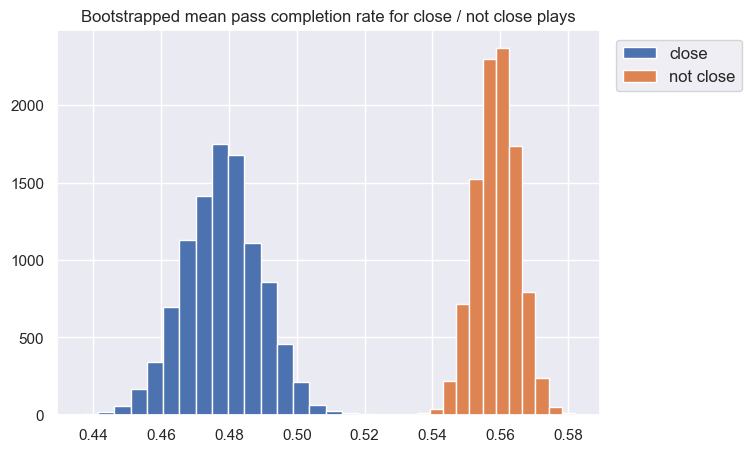

In [22]:
plt.figure(figsize=(7, 5))
plt.title('Bootstrapped mean pass completion rate for close / not close plays')

close_2_prop.hist(bins=18, label='close')
not_close_2_prop.hist(bins=12, label='not close')

plt.legend(loc=(1.03, 0.84), prop={'size': 12})
plt.show()

At a closeness threshold of 2 yards, the average pass success rate is 16 percent higher when the quarterback hasn't been pressured until the ball release.

### Effect of `Decision Time` on Pass Result

Lets calculate the decision time. We will define it as follows.
- If `close` == 1, `decision_time` is the number of seconds between `snap_moment` and `close_moment`.
- If `close` == 0, `decision_time` is the number of seconds between `snap_moment` and `pass_moment`.

In [23]:
decision_time_df = play_results_2_df[~play_results_2_df.snap_moment.isna()]

In [24]:
decision_time_df['decision_time'] = np.where(
    decision_time_df.close == 1,
    (decision_time_df.close_moment - decision_time_df.snap_moment).dt.total_seconds(),
    (decision_time_df.pass_moment - decision_time_df.snap_moment).dt.total_seconds()
)

In [25]:
decision_time_df.decision_time.describe()

count    7583.000000
mean        2.743571
std         1.025439
min        -0.500000
25%         2.200000
50%         2.600000
75%         3.100000
max        19.200000
Name: decision_time, dtype: float64

In [26]:
complete_df = decision_time_df[decision_time_df.pass_result == 'C']
incomplete_df = decision_time_df[decision_time_df.pass_result != 'C']

Lets see if the decision time has any effect on pass result.

**H0:** Distributions of decision times in games with complete passes and games with incomplete passes **are equal**.\
**H1:** Distributions of decision times in games with complete passes and games with incomplete passes **are NOT equal**.

In [27]:
complete_time = complete_df[complete_df.decision_time > 0].decision_time
incomplete_time = incomplete_df[incomplete_df.decision_time > 0].decision_time

In [28]:
stat, p = stats.mannwhitneyu(complete_time, incomplete_time)
print(f'stat={stat:.2f}, p={p}')
if p > .05:
    print('We fail to reject the null hypothesis.')
else:
    print('We reject the null hypothesis and accept H1.')

stat=5715256.00, p=2.446510547129209e-30

We reject the null hypothesis and accept H1.


Lets do a bootstrap and examine the difference between mean decision times for complete and incomplete passes.

In [29]:
state = np.random.RandomState(36)

complete_mean = []
incomplete_mean = []


for i in tqdm.tqdm(range(10000)):
    subsample_complete = complete_time.sample(
        frac=1,
        replace=True,
        random_state=state
    )
    subsample_incomplete = incomplete_time.sample(
        frac=1,
        replace=True,
        random_state=state
    )

    
    complete_mean.append(subsample_complete.mean())
    incomplete_mean.append(subsample_incomplete.mean())

complete_mean = pd.Series(complete_mean)
incomplete_mean = pd.Series(incomplete_mean)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4273.07it/s]


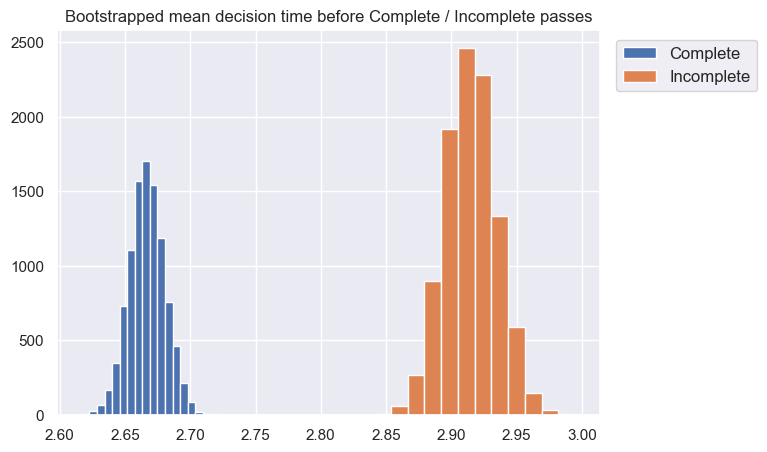

In [30]:
plt.figure(figsize=(7, 5))
plt.title('Bootstrapped mean decision time before Complete / Incomplete passes')

complete_mean.hist(bins=18, label='Complete')
incomplete_mean.hist(bins=12, label='Incomplete')

plt.legend(loc=(1.03, 0.84), prop={'size': 12})
plt.show()

At a closeness threshold of 2 yards, quarterbacks spent 10% less time before making a successful pass.

## Metric

Adding posession team name column:

In [31]:
decision_time_df['possession_team'] = plays.possession_team

**Average `Decision Time` per team**

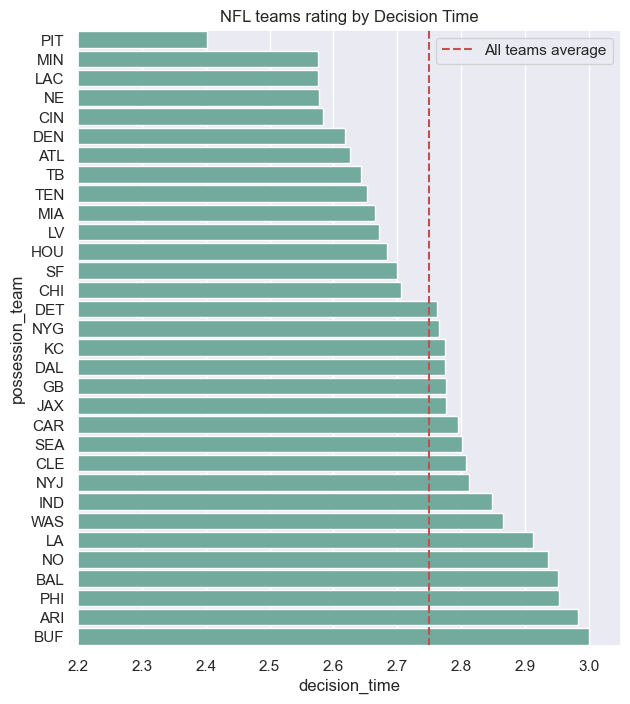

In [32]:
avg_dt_team = pd.DataFrame(
    decision_time_df.groupby('possession_team').decision_time.mean().sort_values(ascending=True)
).reset_index()

plt.figure(figsize=(7, 8))

sns.barplot(
    data=avg_dt_team,
    y='possession_team',
    x='decision_time',
    width=.85,
    color='#69b3a2')
plt.axvline(avg_dt_team.decision_time.mean(), label='All teams average', linestyle='--', color='r')

plt.title('NFL teams rating by Decision Time')
plt.xlim(2.2, 3.05)
plt.legend()
plt.show()

**Post-game stats**

Post-game statistics for game #2021090900 between DAL and TB.

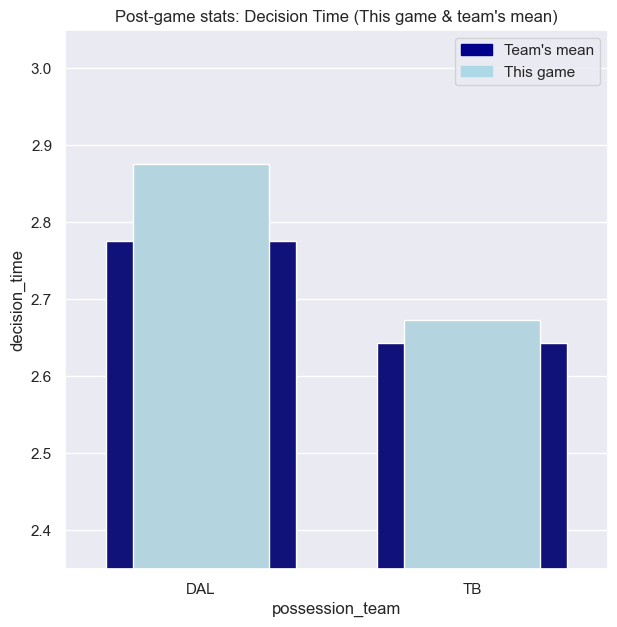

In [33]:
plt.figure(figsize=(7, 7))

teams_mean = (
    decision_time_df
    .groupby('possession_team')
    .mean(numeric_only=True)
    .loc[['DAL', 'TB'], :]
    .reset_index()
)
teams_current = (
    decision_time_df
    .groupby(['gameId', 'possession_team'])
    .mean(numeric_only=True)
    .loc[2021090900]
    .reset_index()
)
bar1 = sns.barplot(x="possession_team",  y="decision_time", data=teams_mean, width=.7, color='darkblue')
bar2 = sns.barplot(x="possession_team", y="decision_time", data=teams_current, width=.5, color='lightblue')

mean_bar = mpatches.Patch(color='darkblue', label="Team's mean")
current_bar = mpatches.Patch(color='lightblue', label='This game')
plt.legend(handles=[mean_bar, current_bar])

plt.title("Post-game stats: Decision Time (This game & team's mean)")
plt.ylim(2.35, 3.05)
plt.show()

**Pre-game stats**

Pregame statistics for game #2021101007 between MIA and TB.

In [34]:
pre = pd.DataFrame({
    'possession_team': ['MIA', 'TB', 'MIA', 'TB', 'MIA', 'TB'],
    'decision_time': [
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021091905, 'MIA'], 'decision_time']
        ),
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021091910, 'TB'], 'decision_time']
        ),
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021092610, 'MIA'], 'decision_time']
        ),
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021092611, 'TB'], 'decision_time']
        ),
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021100304, 'MIA'], 'decision_time']
        ),
        (
            decision_time_df
            .groupby(['gameId', 'possession_team'])
            .mean(numeric_only=True)
            .loc[pd.IndexSlice[2021100313, 'TB'], 'decision_time']
        )
    ]
})

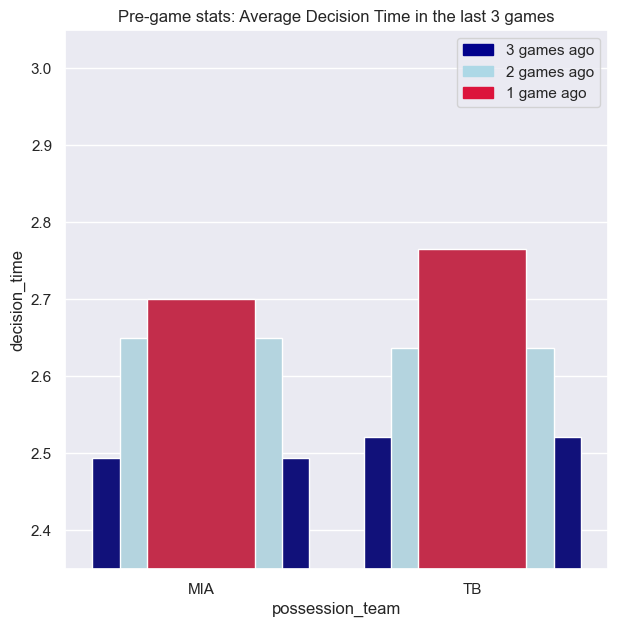

In [35]:
plt.figure(figsize=(7, 7))

bar1 = sns.barplot(x="possession_team",  y="decision_time", data=pre[:2], width=.8, color='darkblue')
bar2 = sns.barplot(x="possession_team", y="decision_time", data=pre[2:4], width=.6, color='lightblue')
bar3 = sns.barplot(x="possession_team", y="decision_time", data=pre[4:], width=.4, color='crimson')


bar_minus_3 = mpatches.Patch(color='darkblue', label='3 games ago')
bar_minus_2 = mpatches.Patch(color='lightblue', label='2 games ago')
bar_minus_1 = mpatches.Patch(color='crimson', label='1 game ago')
plt.legend(handles=[bar_minus_3, bar_minus_2, bar_minus_1])

plt.title('Pre-game stats: Average Decision Time in the last 3 games')
plt.ylim(2.35, 3.05)
plt.show()